In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import sys
import numpy as np
import pyccl as ccl
sys.path.append('./modules/')
import ModelClusterAbundance
import simulation
import matplotlib.pyplot as plt
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
        

# Define Count and lensing mass models

In [2]:
ClusterAbundanceObject = ModelClusterAbundance.UniversePrediction( default_config_path='./config/capish.ini')

In [3]:
params_default = ClusterAbundanceObject.params_default 
cosmo_fid = params_default['CCL_cosmology']
params_new = params_default
compute_new= {'compute_dNdzdlogMdOmega':False,'compute_richness_mass_relation':False, 
               'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':False,
             'compute_dNdzdlogMdOmega_log_slope': False}
adds_new={'add_purity':True, 'add_completeness':True}

In [4]:
adds_new={'add_purity':True, 'add_completeness':True}
N1 = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)
adds_new={'add_purity':True, 'add_completeness':False}
N2 = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)
adds_new={'add_purity':False, 'add_completeness':True}
N3 = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)
adds_new={'add_purity':False, 'add_completeness':False}
N4 = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)

In [5]:
simulator = simulation.UniverseSimulator( default_config_path = './config/capish.ini', 
                                         variable_params_names = ['Omega_m', 'sigma_8'])

In [6]:
def write_script(name):
    with open(f"/pbs/throng/lsst/users/cpayerne/capish/validation_standard/{name}.py", "w") as f:
        f.write(f"""
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/')
import modules.simulation as simulation
import pyccl as ccl
import configparser
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm
import numpy as np
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

def f_to_map(n):
    np.random.seed(n)
    print(f"Starting simulation" +str(n), flush=True)
    return simulator.run_simulation([0.26, 0.8])

def map(func, iterable, ncores=3):
    with Pool(processes=ncores) as pool:
        results = list(tqdm(pool.imap(func, iterable), total=len(iterable), desc="# progress ..."))
    return results

if __name__ == "__main__":
    default_config_path = '/pbs/throng/lsst/users/cpayerne/capish/config/capish.ini'
    default_config = configparser.ConfigParser()
    default_config.read(default_config_path)
    #default_config['cluster_catalogue']['add_completeness'] = 'False'
    #default_config['cluster_catalogue']['add_purity'] = 'False'
    simulator = simulation.UniverseSimulator(
                                default_config=default_config, 
                                variable_params_names=['Omega_m', 'sigma_8'])
    
    results = map(f_to_map, np.arange(30), ncores=10)
    save_pickle(results, '/pbs/throng/lsst/users/cpayerne/capish/validation_standard/{name}.pkl')
            """)

In [7]:
#write_script('sims_incomplete_impure')

In [8]:
#!python /pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_incomplete_impure.py


In [9]:
res_no_completeness = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_no_completeness.pkl')
res_no_purity = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_no_purity.pkl')
res_incomplete_impure = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_incomplete_impure.pkl')
res_no_completeness_no_purity = load('/pbs/throng/lsst/users/cpayerne/capish/validation_standard/sims_no_completeness_no_purity.pkl')

In [10]:
N_no_completeness_no_purity = np.average(np.array(res_no_completeness_no_purity)[:,0], axis=0)
N_incomplete_impure = np.average(np.array(res_incomplete_impure)[:,0], axis=0)

N_no_purity = np.average(np.array(res_no_purity)[:,0], axis=0)

N_no_completeness = np.average(np.array(res_no_completeness)[:,0], axis=0)


In [11]:
N_no_completeness_no_purity

array([[2.26912667e+04, 3.54006333e+04, 2.09021633e+05, 9.95669667e+04],
       [1.05807333e+04, 1.57296333e+04, 8.06108333e+04, 3.19277667e+04],
       [2.58303333e+03, 3.58136667e+03, 1.47858000e+04, 4.34640000e+03],
       [5.57400000e+02, 6.84800000e+02, 2.19430000e+03, 4.35333333e+02],
       [6.98333333e+01, 7.22666667e+01, 1.75000000e+02, 1.96333333e+01]])

/tmp/ipykernel_128798/3404886563.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C2" (-> color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)). The keyword argument will take precedence.
  plt.plot(ClusterAbundanceObject.richness_centers,N1[:,i]/alls, 'C2',label = 'TH, not complete, not pure', alpha=0.6, color='grey')


(20.0, 180.0)

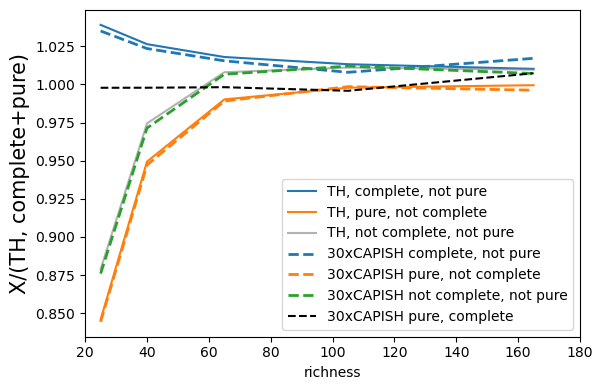

In [20]:
plt.figure(figsize=(6,4))
from matplotlib.ticker import ScalarFormatter
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().xaxis.set_minor_formatter(ScalarFormatter())
plt.ticklabel_format(style='plain', axis='x')
for i in range(2,4):
    alls = N4[:,i]
    plt.plot(ClusterAbundanceObject.richness_centers,N2[:,i]/alls, 'C0', label = 'TH, complete, not pure')
    plt.plot(ClusterAbundanceObject.richness_centers,N3[:,i]/alls, 'C1',label = 'TH, pure, not complete')
    plt.plot(ClusterAbundanceObject.richness_centers,N1[:,i]/alls, 'C2',label = 'TH, not complete, not pure', alpha=0.6, color='grey')
    
    plt.plot(ClusterAbundanceObject.richness_centers,N_no_completeness[:,i]/alls, '--C0', lw=2, label = '30xCAPISH complete, not pure')
    plt.plot(ClusterAbundanceObject.richness_centers,N_no_purity[:,i]/alls, '--C1',lw=2, label = '30xCAPISH pure, not complete')
    plt.plot(ClusterAbundanceObject.richness_centers,N_incomplete_impure[:,i]/alls, '--C2', lw=2,label = '30xCAPISH not complete, not pure')

    
    plt.plot(ClusterAbundanceObject.richness_centers,N_no_completeness_no_purity[:,i]/alls, '--k', label = '30xCAPISH pure, complete')
    break
plt.xlabel('richness')
plt.ylabel('X/(TH, complete+pure)', fontsize=15)
plt.legend()
plt.tight_layout()
#plt.xscale('log')
plt.xlim(20, 180)